In [1]:
n = 10000
p = 100

In [2]:
from numpy.linalg import qr as _QR_DECOMPOSITION, pinv as _PINV, multi_dot as _MULTI_DOT, lstsq as _LSTSQ, svd as _SVD
from numpy import multiply as _MULTIPLY, divide as _DIVIDE, sqrt as _SQRT, log as _LOG, subtract as _SUBTRACT, square as _SQUARE
from numpy import finfo as _INFO, einsum as _EINSUM
from scipy.linalg.lapack import clapack
_TRI_INVERSE = clapack.strtri
from scipy.linalg import pinvh as _SYMMETRIC_PINV, svd as _STABLE_SVD, qr as _STABLE_QR, pinv2 as _STABLE_PINV,\
                        lstsq as _STABLE_LSTSQ
from sklearn.base import BaseEstimator, RegressorMixin
from numba import jit

def _fast_QR_solve(X, y):
    ''' Tried many types:
    1. np.linalg.inv
        Good, but slow.
    2. np.linalg.pinv
        Also good. Handles singular matrices (like all 0s). No need since preprocessing removes all zero columns.
    3. lapack.clapack.strtri (TRI_INVERSE)
        Very good, as strtri inverts a triangular matrix. Also faster than numpy.
    4. lapack.clapack.dtrtri
        Same as strtri, just doubles. strtri is faster.
    5. scipy.solve_triangular
        Good, however, I experienced unstable issues unfortunately.'''
    #Q, R = _QR_DECOMPOSITION(X)   Numpy's actually slower than scipy for large matrices!
    Q, R = _STABLE_QR(X, check_finite = False, mode = 'economic')
    check = 1

    if R.shape[0] == R.shape[1]:
        _R, check = _TRI_INVERSE(R)
    if check > 0:
        rcond = _INFO(X.dtype).eps * max(X.shape)
        #_R = _PINV(R, rcond = rcond)     # FALL BACK if fails (normally if p >> n) or singular matrix error still
        _R = _STABLE_PINV(R, check_finite = False)

    '''Multi Dot is much much faster as it orders the matrices properly before actual matmul
        In fact, (_R*Q.T)*y has cost O(npy+np^2y) whilst
                 _R*(Q.T*y) has cost O(npy+p^2y), a factor of n lower!'''
    theta_hat = _R.dot(Q.T.dot(y))   # Same as theta_hat = _MULTI_DOT([_R, Q.T, y])
    _R = None
    return Q, R, theta_hat

def _fast_lstsq(X, y):
    '''If p/n >= 0.2, then reverts to QR Decomposition with Fast LAPACK Triangular Inverse
        Else, use Numpy"s LSTSQ (Fast SVD version)'''
    n,p = X.shape
    if p / n >= 0.2:
        theta_hat, __, __, __ = _LSTSQ(X, y, check_finite = False)
    else:
        theta_hat, __, __ = _fast_QR_solve(X, y)

def _transpose_lstsq(X, y):
    U, S, VT = _transpose_svd(X)
    if U is None:
        return None
    else:
        theta_hat = _MULTI_DOT([_MULTIPLY(V, _DIVIDE(1, S).reshape(1,-1)),
                               U.T, y])
    return theta_hat

def _fast_svd(X):
    #Q, R = _QR_DECOMPOSITION(X)   Numpy is slower
    Q, R = _STABLE_QR(X, check_finite = False, mode = 'economic')
    U2, S, VT, i = _transpose_svd(R)
    if i == 0: 
        #U2, S, VT = _SVD(R, full_matrices = False)  Numpy is unstable
        U2, S, VT = _STABLE_SVD(R, full_matrices = False, check_finite = False)
    R = None
    gc.collect();
    U = Q.dot(U2)
    return U, S, VT

def _memory_lstsq(X, y):
    '''Computes least squares with lower memory requirements if memory error seen'''
    theta_hat, __, __, __ = _STABLE_LSTSQ(X, y, check_finite = False, lapack_driver = 'gelss')
    return theta_hat

def _transpose_svd(X):
    if X.shape[0] < X.shape[1]:
        #V, S, UT = _SVD(X.T, full_matrices = False)  Numpy is unstable
        V, S, UT = _STABLE_SVD(X.T, full_matrices = False, check_finite = False)
        U = UT.T
        VT = V.T
        return U, S, VT, 1
    else:
        return None, None, None, 0

def _qr_stats(Q, R):
    XTX = R.T.dot(R)
    rcond = _INFO(X.dtype).eps * max(X.shape)

    #_XTX = _PINV(XTX)  Numpy is slower
    _XTX = _STABLE_PINV(XTX, check_finite = False)
    h = _EINSUM('ij,ij->i', Q, Q)
    return _XTX, h

def _svd_stats(U, S, VT):
    _S2 = _DIVIDE(1, _SQUARE(S))
    VS = _MULTIPLY(VT.T, _S2.reshape(1,-1))   # Faster than VT.T.dot(np.diag(S)) [14us vs 109us]

    _XTX = VS.dot(VT)
    
    h = _EINSUM('ij,ij->i', U, U)   # Faster than U.dot(U.T).diagonal() [43us vs 7.5ms]
    return _XTX, h

def _pinv_stats(X):
    #pinv = _PINV(X)  Numpy is slower
    pinv = _STABLE_PINV(X, check_finite = False)
    h = _EINSUM('ij,ji->i', X, pinv)
    
    XTX = X.T.dot(X)
    #_XTX = _PINV(XTX)  Numpy is slower
    _XTX = _STABLE_PINV(XTX, check_finite = False)
    return _XTX, h

def _svd_solve(X, y):
    U, S, VT = _STABLE_SVD(X, full_matrices = False, check_finite = False)
    VT *= _DIVIDE(1, S).reshape(-1,1)
    theta_hat = VT.T.dot(U.T.dot(y))
    return theta_hat
    
    
%load_ext memory_profiler
import numpy as np, gc, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
X = np.random.random((n,p))
X[:,1] = 0
X[:,2] *= 2
X[:,10] *= -2
X[:,5] *= 3.5
X[1,1] = 1
X[:,3] = 1
X[:int(n/2),5] *= -1
X[:int(n/2),10] *= -1
X = X.astype(np.float32, copy = False)
theta = np.random.random((p,1))
theta = theta.astype(np.float32, copy = False)
y = (X@theta).flatten()
y = y.astype(np.float32, copy = False)
y = y.astype(np.int)

results = [n,p]

In [3]:
eX = np.exp(-X.dot(theta))
eX2 = np.square(1+eX)
np.divide(eX, eX2)

array([[6.1460071e-13],
       [5.4955732e-12],
       [2.5457310e-11],
       ...,
       [3.7332314e-11],
       [2.1772152e-13],
       [1.3263663e-13]], dtype=float32)

In [11]:
f = np.divide(np.exp(X.dot(theta)), 1+np.exp(X.dot(theta)))
np.multiply(f, 1-f)

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [68]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept = False, normalize = False, n_jobs = -1)

In [ ]:
@njit( [ Tuple((matrix32, float32[:], matrix32))  (matrix32) ,
         Tuple((float64[:,:], float64[:], float64[:,:]))  (float64[:,:]) ] , fastmath = True, nogil = True)
def svdT(X):
    V, S, UT = np_svd(X.T, full_matrices = False)
    U = UT.T
    VT = V.T
    return U, S, VT

def svd_flip(U, S, VT):
    max_in_cols = np_abs(U).argmax(0)
    signs = np_sign(U[max_in_cols, np_arange(U.shape[1])])
    U *= signs
    VT *= signs.reshape(-1,1)
    
def svd(X):
    if X.shape[1] > X.shape[0]:
        U, S, VT = svd_flip(X)
    else:
        U, S, VT = base_svd(X)
    svd_flip(U, S, VT)
    return U, S, VT

In [4]:
import numba

In [7]:
numba.typeof(np_svd(X))

(array(float32, 2d, C), array(float32, 1d, C), array(float32, 2d, C))

In [21]:
float32[:,::1]

array(float32, 2d, C)

In [5]:
%%time
from numpy.linalg import svd as np_svd, lstsq as np_lstsq, qr as np_qr, pinv as np_pinv                
from numpy import finfo as np_finfo, divide as np_divide, dot as np_dot, multiply as np_multiply, \
                    einsum, square as np_square, newaxis as np_newaxis, log as np_log, sqrt as np_sqrt, \
                    arange as np_arange, array as np_array, argmax as np_argmax, sign as np_sign, \
                    abs as np_abs
from numba.types import Tuple, float32, float64, int32, int64, Array, UniTuple
from numba import njit, jit
from scipy.stats import t as tdist

matrix32 = float32[:,:]
matrix64 = float64[:,:]
array32 = float32[:]
array64 = float64[:]
int32A = int32[:]
int64A = int64[:]

def column(a): return a[:,np_newaxis]
def row(a): return a[np_newaxism,:]

Wall time: 634 ms


In [6]:
@njit( [ Tuple((matrix32, array32, matrix32))  (matrix32) ,
         Tuple((matrix64, array64, matrix64))  (matrix64) ] , fastmath = True, nogil = True)
def _svd(X):
    return np_svd(X, full_matrices = False)


@njit( [ UniTuple(matrix32, 2)  (matrix32) ,
         UniTuple(matrix64, 2)  (matrix64) ] , fastmath = True, nogil = True)
def qr(X):
    return np_qr(X)


@njit( [ Tuple((array32, array32, int32, array32))  (matrix32, array32) ,
         Tuple((array64, array64, int64, array64))  (matrix64, array64) ,
         Tuple((array32, array32, int32, array32))  (matrix32, int32A) ,
         Tuple((array64, array64, int64, array64))  (matrix64, int64A) ] , fastmath = True, nogil = True)
def lstsq(X, y):
    return np_lstsq(X, y.astype(X.dtype))


@njit( [ matrix32(matrix32) , matrix64(matrix64) ] , fastmath = True, nogil = True)
def pinv(X):
    U, S, VT = np_svd(X, full_matrices = False)
    cond =  S < np_finfo(X.dtype).eps*S[0] 
    S = np_divide(1.0, S)
    S[cond] = 0.0
    VT *= S.reshape(-1,1)
    return np_dot(VT.T, U.T)

def svd_flip(U, S, VT):
    max_U = np_argmax(np_abs(U), axis = 0)
    signs = np_sign(U[max_U, range(U.shape[1])])
    U *= signs
    VT *= signs[:, np_newaxis]
    
def svd(X):
    U, S, VT = _svd(X)
    svd_flip(U, S, VT)
    return U, S, VT


# @njit( [ matrix32  (matrix32, matrix32) , matrix64  (matrix64, matrix64) ,
#          array32  (matrix32, array32) , array64  (matrix64, array64) ] , fastmath = True, nogil = True)
# def dot(a, b):
#     return np_dot(a, b)


# @njit( [ matrix32  (matrix32, matrix32) , 
#          matrix64  (matrix64, matrix64) ] , fastmath = True, nogil = True)
# def multiply(a, b):
#     return np_multiply(a, b)

# @njit( [matrix32(matrix32) , matrix64(matrix64) , 
#         array32(array32), array64(array64) ] , fastmath = True, nogil = True)
# def square(A):
#     return np_square(A)

In [44]:
# @njit( [ void (matrix32, float32[:], matrix32) ,
#          void (float64[:,:], float32[:], matrix32) ] , fastmath = True, nogil = True)
# def svd_flip(U, S, VT):
#     max_in_cols = np_abs(U).argmax(1)
#     signs = U[max_in_cols, np_arange(U.shape[1])]
#     U *= signs
#     VT *= signs.reshape(-1,1)

In [7]:
U, S, VT = svd(X)

In [8]:
def qr_solve(X, y):
    '''
    theta =  R^-1 * QT * y
    '''
    Q, R = qr(X)
    check = 0
    if R.shape[0] == R.shape[1]:
        _R, check = clapack.strtri(R)
    if check > 0:
        _R = pinv(R)
    
    theta_hat = _R.dot( Q.T.dot( y.ravel().astype(X.dtype) ) )
    return Q, R, theta_hat


def svd_solve(X, y):
    '''
    theta =  V * S^-1 * UT * y
    '''
    U, S, VT = svd(X)
    cond = S < np_finfo(X.dtype).eps*S[0]
    _S = np_divide(1.0, S)
    _S[cond] = 0.0
    
    theta_hat = np_multiply( VT.T, _S ).dot( U.T.dot( y.astype(X.dtype) ) )
    return theta_hat


def ridge_solve(X, y, alpha = 1):
    '''
                    S
    theta =   V --------- UT y 
                 S^2 + aI
    '''
    U, S, VT = svd(X)
    cond = S < np_finfo(X.dtype).eps*S[0]
    _S = np_divide(S, np_square(S)+alpha )
    _S[cond] = 0.0
    
    theta_hat = np_multiply( VT.T, _S ).dot( U.T.dot( y.astype(X.dtype) ) )
    return theta_hat


def qr_stats(Q, R):
    '''
    XTX^-1  =  RT * R
    
    h = diag  Q * QT
    '''
    XTX = R.T.dot(R)
    _XTX = pinv(XTX)
    h = einsum('ij,ij->i', Q, Q)
    return _XTX, h


def svd_stats(U, S, VT):
    '''
                  1
    XTX^-1 =  V ----- VT 
                 S^2
    
    h = diag U * UT
    '''
    _S2 = np_divide(1.0, np_square(S))
    VS = np_multiply( VT.T, _S2 )
    _XTX = VS.dot(VT)
    h = einsum('ij,ij->i', U, U)
    return _XTX, h


def ridge_stats(U, S, VT, alpha = 1):
    '''
                               S^2
    exp_theta_hat =  diag V --------- VT
                            S^2 + aI
                            
                                 S^2
    var_theta_hat =  diag V ------------- VT
                            (S^2 + aI)^2
    
                    1
    XTX^-1 =  V --------- VT
                S^2 + aI
    '''
    V = VT.T
    S2 = np_square(S)
    S2_alpha = S2 + alpha
    
    VS = np_multiply(   V,   np_divide( S2,  S2_alpha )  )
    exp_theta_hat = einsum('ij,ji->i', VS, VT)     # Same as VS.dot(VT)
    
    V_S2 = np_divide(  VS,  S2_alpha )  # np_divide(S2,  np_square( S2 + alpha ) )
    var_theta_hat = einsum('ij,ij->i',  V_S2  , V)   # Sams as np_multiply(   V,   V_S2 ).sum(1)
    
    _XTX = np_multiply(  V,  np_divide( 1.0,  S2_alpha )  ).dot( VT )   # V  1/S^2 + a  VT
    
    return exp_theta_hat, var_theta_hat, _XTX

In [9]:
def ridgeAIC(X, y, alphas = np_arange(1,100,2)):
    results = _ridge_alpha(X, y, alphas, method = 'AIC')
    best = results.argmin()
    return alphas[best]


def ridgeCV(X, y, alphas = np_arange(1,100,2)):
    results = _ridge_alpha(X, y, alphas, method = 'CV')
    best = results.argmin()
    return alphas[best]


def _ridge_alpha(X, y, alphas, method = 'CV'):
    U, S, VT = svd(X)
    n,p = X.shape
    n_p = n-p
    cond = S < np_finfo(X.dtype).eps*S[0]
    S[cond] = 0
    ys = y.astype(X.dtype)
    S_square = np_square(S)
    V = VT.T
    UTy = U.T.dot( ys )
    
    _2pi = np_sqrt(2*np.pi)
    results = []
    
    for alpha in alphas:
        _S = np_divide(S, ( S_square + alpha ) )
        S_S = np_multiply(  S, _S )
        
        theta_hat = np_multiply( V, _S ).dot( UTy )
        e_hat = y - X.dot(theta_hat)

        e_hat_square_sum = np_square(e_hat).sum()
        sigma_hat2 = e_hat_square_sum / n_p

        if method == 'CV':
            U_S = np_multiply(  U,  S_S  )
            h = einsum('ij,ij->i', U_S, U)
            
            press_alpha = np_multiply(   np_divide( 1.0, (1-h) ) ,  e_hat)
            LOOCV_alpha = 1.0/n * np_square(press_alpha).sum()
            results.append(LOOCV_alpha)
            
        elif method == 'AIC':
            _2p = 2 * S_S.sum()
            _2logL = 2*n*np_log(  _2pi  * np_sqrt(sigma_hat2) ) + 1/sigma_hat2*e_hat_square_sum
            AIC = _2p + _2logL
            results.append(AIC)   
            
    return np_array(results)


def get_tvalue(df, interval = 0.95, method = 'normal'):
    '''
    1) Normal alpha
                               a
         T value =   T ( 1 - -----   ,  n-p )
                               2
    2) Sidak Correction
                                       (1/p)
                             1 - (1-a)^ 
         T value =   T ( 1 - ---------       ,  n-p )
                                2
    3) Bonferroni Correction
                               a
         T value =   T ( 1 - -----   ,  n-p )
                              2p
    '''
    alpha = 1-interval
    if method == 'sidak':
        alpha = 1-(1-alpha)**(1/p)
    elif method == 'bonferroni':
        alpha = 1-(1-alpha/p)
    tvalue = tdist.ppf( (1-alpha/2), df)
    return tvalue


def get_pvalues(coefficients, std_error, df):
    '''
    2 Sided Partial T Test
    
    pvalue = P( T(n-p) >= t statistic )
           = 2 * ( 1 - P ( T(n-p) < t statistic) )
    
                    theta_hat - 0 * exp_theta_hat      theta_hat
    t statistic =  -------------------------------  = ------------
                             std_error                 std_error
    '''
    z_scores = np_divide(coefficients, std_error)
    pvalues = 2*(1-tdist.cdf( np_abs(z_scores), df))   # 2 sided
    return pvalues


def get_confint(coefficients, expected_value, std_error, df, interval = 0.95, method = 'normal'):
    '''
    CI (theta_hat) =  (  theta_hat * exp_value_theta_hat  -  std_error * tvalue ,
                         theta_hat * exp_value_theta_hat  +  std_error * tvalue  )
    '''
    tvalue = get_tvalue(df, interval, method)
    
    exp_coef = np_multiply( expected_value  ,  coefficients )
    std_t = np_multiply( std_error  ,  tvalue )
    
    return exp_coef-std_t, exp_coef+std_t


def holm_bonferroni(pvalues, df, interval = 0.95):
    '''
    Sort smallest to largest giving ranks (1,...,p)
    
                     a              0.05
    Rank Alpha =  -------    (eg:  -------   )
                   ranks             20
    
    Holm Bonferroni Procedure says P-values must be smaller than Rank Alpha to reject null hypothesis
    '''
    alpha = 1-interval
    ranks = (-pvalues).argsort() + 1
    holm_bonferroi = alpha / ranks
    reject_null = pvalues < holm_bonferroi
    return reject_null

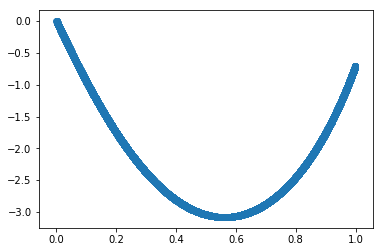

In [246]:
X = np.random.random((10000,1))
X = np.hstack((X, X**2.3))
y = X[:,0]*-10 + X[:,1]*10 - 2*X[:,1]**2 + 1.3*X[:,1]**3
plt.scatter(X[:,0], y)

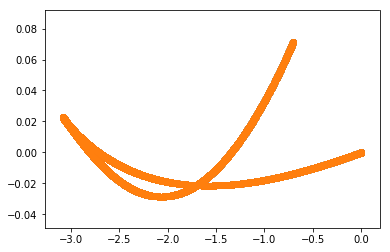

In [248]:
plt.scatter(y, e_hat)
plt.scatter(y, e_GLS)

In [290]:
from sklearn.svm import SVR

In [379]:
theta_hat = svd_solve(X, y)
e_hat = y - X.dot(theta_hat)

log_e_hat2 = np.log( np.square(e_hat) )

# model = SVR(kernel = 'poly', C = 0.0001)
# model.fit(X, log_e_hat2)
# h_hat = np.exp(  model.predict(X)  )

# # theta_g_hat = ridge_solve(X, log_e_hat2)
# # h_hat = np.exp(  X.dot(theta_g_hat)  )

# W = (1/h_hat)
# XTW = np_multiply(X.T, W)
# theta_GLS2 = pinv(XTW.dot(X)).dot(XTW).dot(y)
# e_GLS = y - X.dot(theta_GLS2)
# (e_GLS**2).sum().round(7), (e_hat**2).sum().round(7)

In [392]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(X, np.square(e_hat))

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [393]:
h_hat = model.predict(X)

W = (1/h_hat)
XTW = np_multiply(X.T, W)
theta_GLS2 = pinv(XTW.dot(X)).dot(XTW).dot(y)
e_GLS = y - X.dot(theta_GLS2)
(e_GLS**2).sum().round(7), (e_hat**2).sum().round(7)

(3.5601542, 3.4674791)

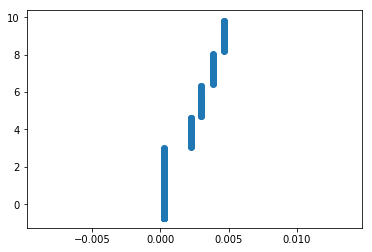

In [391]:
plt.scatter(model.predict(X), std_log_e_hat)

In [286]:
x = X[:,1]
N = 5
length = int(len(X)/N)
a = 4

y_y = y - np.mean(y)
x_x = x - np.mean(x)

numerator = np_multiply(x_x, y_y).sum()
denominator = np.sqrt(   np.square(x_x).sum() * np_square(y_y).sum()  )
numerator/denominator, length

(-0.05943565810098133, 2000)

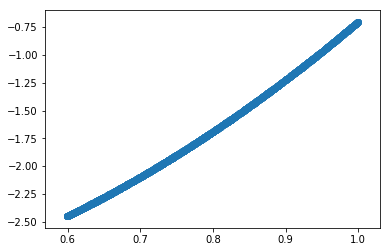

In [287]:
section = np.vstack( (x, y) ).T[x.argsort()]
plt.scatter(section[length*a:length*(a+1),0] , section[length*a:length*(a+1),1])

In [120]:
model = LGBMRegressor(n_jobs = -1)
model.fit(X, log_e_hat2)
model.predict(X)

array([0.10640742, 0.06316554, 0.06195185, ..., 0.05613877, 0.08515529,
       0.063564  ])

(array([  1.,   1.,   0.,   2.,   3.,   2.,   2.,   7.,   5.,   1.,   4.,
          8.,   8.,  10.,   4.,  15.,  13.,   9.,  12.,  15.,  18.,  16.,
         29.,  31.,  25.,  34.,  23.,  35.,  51.,  40.,  60.,  69.,  56.,
         64.,  81.,  95.,  92., 107.,  87., 103., 100.,  85., 110., 143.,
        112., 149., 151., 121., 154., 170., 147., 130., 159., 165., 177.,
        173., 199., 193., 170., 198., 230., 208., 209., 204., 207., 234.,
        205., 223., 210., 193., 202., 196., 173., 177., 185., 192., 150.,
        148., 135., 167., 162., 132., 148., 120., 124., 133., 128., 117.,
        100., 103.,  99.,  80.,  78.,  82.,  81.,  77.,  57.,  44.,  34.,
          9.]),
 array([0.80606734, 0.80800563, 0.80994391, 0.81188219, 0.81382048,
        0.81575876, 0.81769704, 0.81963533, 0.82157361, 0.82351189,
        0.82545018, 0.82738846, 0.82932674, 0.83126503, 0.83320331,
        0.83514159, 0.83707988, 0.83901816, 0.84095644, 0.84289473,
        0.84483301, 0.84677129, 0.84870958, 0.

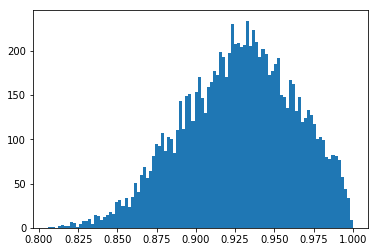

In [118]:
plt.hist(W, bins = 100)

In [110]:
X.dot(theta_g_hat).round(4)

array([0.0709, 0.    , 0.0768, ..., 0.0787, 0.0657, 0.0795], dtype=float32)

In [564]:
pd.DataFrame(np.vstack((get_confint(theta_hat, expected_value, std_error, n-p, interval = 0.95, method = 'sidak'),
               get_confint(theta_hat, expected_value, std_error, n-p, interval = 0.95, method = 'normal'),
                       holm_bonferroni(pvalues, n-p), pvalues
                       )
             )).T.sort_values(5).round(4)

,0,1,2,3,4,5
0,0.6419,0.7114,0.6571,0.6962,1.0,0.0000
71,0.2044,0.2736,0.2195,0.2585,1.0,0.0000
69,0.7964,0.8654,0.8114,0.8504,1.0,0.0000
68,0.8758,0.9455,0.8910,0.9304,1.0,0.0000
67,0.4244,0.4934,0.4395,0.4784,1.0,0.0000
66,0.2846,0.3537,0.2996,0.3386,1.0,0.0000
65,0.2274,0.2966,0.2424,0.2815,1.0,0.0000
64,0.6670,0.7361,0.6820,0.7210,1.0,0.0000
63,0.9141,0.9835,0.9292,0.9684,1.0,0.0000
62,0.6719,0.7410,0.6869,0.7259,1.0,0.0000


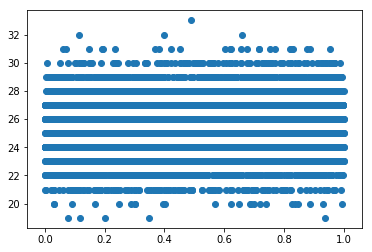

In [553]:
plt.scatter(X[:,], y)

In [500]:
z_scores = theta_hat / std_error
pvalues = 2*(1-tdist.cdf(np_abs(z_scores), n-p))

In [356]:
%%time
U, S, VT = svd(X)
V = VT.T

Wall time: 66 ms


In [180]:
theta_hat = svd_solve(X, y)

In [532]:
alpha = 0.05
pvalues = get_pvalues(theta_hat, std_error, n-p)
ranks = (-pvalues).argsort() + 1
holm_bonferroi = alpha / ranks
reject_null = pvalues < holm_bonferroi

In [533]:
reject_null

array([ True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True])

In [555]:
ridge_stats(U, S, VT)

(array([0.99877936, 0.49729508, 0.9996986 , 0.9719105 , 0.9987731 ,
        0.9999437 , 0.99877465, 0.9987738 , 0.99878514, 0.998774  ,
        0.9998313 , 0.9987929 , 0.998789  , 0.99880165, 0.99879354,
        0.9987918 , 0.99879223, 0.99879634, 0.9987748 , 0.99880606,
        0.99878925, 0.9987864 , 0.99879247, 0.9987936 , 0.99879676,
        0.9988019 , 0.9987861 , 0.99879545, 0.9987818 , 0.99879766,
        0.9987766 , 0.9987894 , 0.99879897, 0.99878985, 0.99878985,
        0.99879456, 0.99880546, 0.9987759 , 0.9987683 , 0.9987901 ,
        0.99877584, 0.9987991 , 0.99880004, 0.9987952 , 0.9987912 ,
        0.99879795, 0.99877506, 0.9987997 , 0.9988114 , 0.99879444,
        0.99880445, 0.99876887, 0.9987958 , 0.9988042 , 0.99881166,
        0.99878556, 0.9987994 , 0.99879223, 0.998779  , 0.9987812 ,
        0.9987948 , 0.99879277, 0.99878997, 0.9987832 , 0.998792  ,
        0.9987885 , 0.9987897 , 0.998798  , 0.99877083, 0.99879426,
        0.9987886 , 0.99879044, 0.9987964 , 0.99

In [403]:
alpha = 10


theta_hat = ridge_solve(X, y, alpha)






e_hat = y - X.dot(theta_hat)
sigma_hat2 = np_square(e_hat).sum() / (n-p)

std_error = np_sqrt(sigma_hat2) * np_sqrt(var_theta_hat)

pvalues = get_pvalues(theta_hat, std_error, n-p)
confint = get_confint(theta_hat, exp_theta_hat, std_error, n-p)

In [397]:
theta_hatLR = svd_solve(X, y)

e_hat = y - X.dot(theta_hatLR)
sigma_hat2 = np_square(e_hat).sum() / (n-p)

_XTX, h = svd_stats(U, S, VT)

std_error = np.sqrt(_XTX.diagonal()) * np.sqrt(sigma_hat2)
expected_value = 1
pd.DataFrame(np.vstack(get_confint(theta_hatLR, expected_value, std_error, n-p))).T

,0,1
0,0.664514,0.704147
1,-0.955064,0.184774
2,0.979379,0.999054
3,-0.351621,-0.158772
4,0.369891,0.409638
5,0.271149,0.279669
6,0.149508,0.189229
7,0.620210,0.659949
8,0.477272,0.516817
9,0.855723,0.895453


In [459]:
pd.DataFrame(np.vstack((confint, theta_hat, pvalues, reject_null))).T.round(5).sort_values(3)

,0,1,2,3,4
0,0.64891,0.68808,0.67664,0.00000,1.0
71,0.21662,0.25563,0.23898,0.00000,1.0
69,0.80151,0.84047,0.83088,0.00000,1.0
68,0.87999,0.91930,0.91070,0.00000,1.0
67,0.43403,0.47292,0.45892,0.00000,1.0
66,0.29583,0.33483,0.31914,0.00000,1.0
65,0.23931,0.27835,0.26196,0.00000,1.0
64,0.67367,0.71264,0.70152,0.00000,1.0
63,0.91783,0.95697,0.94881,0.00000,1.0
62,0.67851,0.71750,0.70644,0.00000,1.0


In [216]:
VS2 = 


array([3.3098757e+03, 1.0000054e+00, 1.3280866e+04, 1.0000002e+04,
       3.2953818e+03, 3.9959098e+04, 3.3271277e+03, 3.2418362e+03,
       3.3766470e+03, 3.3513311e+03, 1.3370564e+04, 3.3278027e+03,
       3.3429973e+03, 3.3903960e+03, 3.3288943e+03, 3.3012959e+03,
       3.3557637e+03, 3.3494333e+03, 3.3466501e+03, 3.3491780e+03,
       3.3386309e+03, 3.3656353e+03, 3.3237383e+03, 3.3867146e+03,
       3.3392017e+03, 3.3429456e+03, 3.3158232e+03, 3.3656968e+03,
       3.3335515e+03, 3.3931687e+03, 3.3605908e+03, 3.3271628e+03,
       3.3640464e+03, 3.3003259e+03, 3.3333813e+03, 3.4003457e+03,
       3.3673474e+03, 3.3427490e+03, 3.3461602e+03, 3.3084912e+03,
       3.3355435e+03, 3.3611794e+03, 3.3232886e+03, 3.3373396e+03,
       3.3133499e+03, 3.3792339e+03, 3.3764436e+03, 3.3331257e+03,
       3.3230059e+03, 3.3365291e+03, 3.3376101e+03, 3.3067678e+03,
       3.3239172e+03, 3.3530774e+03, 3.3377297e+03, 3.3086296e+03,
       3.3094517e+03, 3.3433538e+03, 3.3164985e+03, 3.2875898e

In [156]:
@njit(fastmath = True)
def ridgeCV(X, U, S, VT):
    cast = X.dtype
    cond = S < np_finfo(cast).eps*S[0]
    ys = y.astype(X.dtype)
    
    S_square = np_square(S)
    aics = np.zeros(100-1).astype(cast)
    UT = U.T
    V = VT.T
    _2pi = np.sqrt(2*np.pi)
    i = 0
    
    for alpha in prange(1, 100):
        _S = np_divide(S, ( S_square + alpha*1.0 ) ).astype(cast)
        _S[cond] *= 0.0
    
        theta_hat = np_multiply( V, _S ).dot( U.T.dot( ys ) )
    
        y_hat = X.dot(theta_hat)
        e_hat = y - y_hat

        e_hat_square_sum = np_square(e_hat).sum()
        sigma_hat2 = e_hat_square_sum / (n-p)
        
        U_S = np_multiply(  U,  np_multiply(  S, _S )  )
        h = np_multiply(a, b).sum(1)

        press_alpha = np_multiply(   np_divide( 1.0, (1-h) ) ,  e_hat)
        LOOCV_alpha = 1.0/n * np_square(press_alpha).sum()
        
        _2p = 2 * np_multiply(  S, _S ).sum()
        _2logL = 2*n*np.log(  _2pi  * np.sqrt(sigma_hat2) ) + 1/sigma_hat2*e_hat_square_sum
        AIC = _2p + _2logL
        
#         aics[i] = AIC
    return aics

In [173]:
%%time
ridgeCV(X, U, S, VT)

Wall time: 561 ms


[0.08307331866733231,
 0.0830840281753515,
 0.08310215490654096,
 0.08312678187893599,
 0.08315715723531605,
 0.0831926353875286,
 0.08323266709848368,
 0.0832767902715319,
 0.08332455539370646,
 0.08337568908531823,
 0.08342986258252334,
 0.08348684002986599,
 0.08354639783456985,
 0.08360833484369463,
 0.08367249732578148,
 0.08373875864598547,
 0.08380699516185043,
 0.0838770839475852,
 0.08394894448992495,
 0.08402248848215016,
 0.08409765922458842,
 0.08417439571867133,
 0.08425263591649362,
 0.08433233985669138,
 0.08441346527900233,
 0.08449594222061357,
 0.08457982036708796,
 0.08466500783101011,
 0.08475149115618481,
 0.08483926748909532,
 0.08492830274628257,
 0.08501856225400942,
 0.08511008671377707,
 0.08520279361862539,
 0.08529672492447168,
 0.08539186399512387,
 0.08548817668769852,
 0.08558565465621869,
 0.08568430574289847,
 0.08578413690535022,
 0.08588508489154446,
 0.08598722202911725,
 0.08609051309152847,
 0.08619489451609257,
 0.08630044030286874,
 0.08640710219

In [158]:
%%time
ridgeCV(X, U, S, VT)

Wall time: 1.9 s


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [121]:
%%time


Wall time: 6.24 ms


array([0.01045053, 0.5025717 , 0.00998101, ..., 0.01078435, 0.00944504,
       0.01247544], dtype=float32)

In [122]:
%%time
einsum('ij,ij->i', a, b)

Wall time: 4.96 ms


array([0.01045053, 0.5025717 , 0.00998101, ..., 0.01078435, 0.00944504,
       0.01247544], dtype=float32)

In [37]:
np_multiply(a, b)

array([[-1.9459732e-04, -7.0100800e-06,  2.2696893e-05, ...,
        -1.0414936e-04, -2.9384622e-03, -8.6256980e-05],
       [-3.7605442e-08,  2.2324598e-07,  2.0560976e-06, ...,
         5.9225549e-06,  3.1443167e-04, -4.9998936e-01],
       [-3.9359537e-04,  3.4098305e-06, -1.2637928e-04, ...,
         3.9970441e-04, -1.6369758e-03,  1.2404993e-04],
       ...,
       [-1.9353940e-04,  9.7516868e-06, -1.4149634e-05, ...,
        -1.7097644e-03, -3.7000829e-03, -5.4802742e-05],
       [-1.9285483e-04, -4.6902646e-06,  3.2759312e-05, ...,
         8.9914352e-04, -3.0334196e-03,  2.2237733e-04],
       [-1.9408550e-04,  1.0725395e-05,  1.2732539e-07, ...,
         4.7788685e-03, -3.4125380e-03, -8.2225097e-06]], dtype=float32)

In [303]:
h1 = U.dot(np.diag(S)).dot(np.diag(_S)).dot(np.diag(S)).dot(U.T)

In [319]:
H = X.dot( np.linalg.inv(VT.T.dot(np.diag(S**2)).dot(VT)+ np.eye(X.shape[1])*alpha )).dot(X.T)

In [322]:
H2 = U.dot(np.diag(S)).dot(np.diag(1/(S**2 + alpha))).dot(np.diag(S)).dot(U.T)

In [28]:
U.dot(  np.diag((S**2)/(S**2 + alpha))  ).dot(U.T).diagonal().sum()

176.98645

In [29]:
.dot(U.T).diagonal().sum()

176.98645

In [11]:
_S

array([2.4298915e-04, 1.4898354e-04, 6.0480361e-05, 5.1343453e-05,
       3.0718784e-05, 3.0543244e-05, 3.0491037e-05, 3.0401838e-05,
       3.0366769e-05, 3.0331610e-05, 3.0272480e-05, 3.0206900e-05,
       3.0163996e-05, 3.0142977e-05, 3.0037389e-05, 2.9983934e-05,
       2.9923991e-05, 2.9863892e-05, 2.9823668e-05, 2.9813269e-05,
       2.9778857e-05, 2.9770285e-05, 2.9753928e-05, 2.9659732e-05,
       2.9603085e-05, 2.9584540e-05, 2.9569852e-05, 2.9513249e-05,
       2.9490568e-05, 2.9439310e-05, 2.9378958e-05, 2.9349409e-05,
       2.9339222e-05, 2.9242647e-05, 2.9225024e-05, 2.9175679e-05,
       2.9154668e-05, 2.9147666e-05, 2.9123994e-05, 2.9076287e-05,
       2.9031218e-05, 2.9015258e-05, 2.8970107e-05, 2.8940420e-05,
       2.8900999e-05, 2.8845217e-05, 2.8834758e-05, 2.8783115e-05,
       2.8760049e-05, 2.8721586e-05, 2.8673090e-05, 2.8624085e-05,
       2.8586406e-05, 2.8579461e-05, 2.8552566e-05, 2.8549832e-05,
       2.8515482e-05, 2.8493321e-05, 2.8475717e-05, 2.8447625e

In [282]:
a = ridge_solve(X, y, alpha = 1)
b = ridge_solve(X, y, alpha = 10)
c = ridge_solve(X, y, alpha = 0.1)
d = ridge_solve(X, y, alpha = 20)

(array([ 1.,  1.,  1., 32., 49., 57., 52.,  5.,  1.,  1.]),
 array([1.2171792e-04, 8.9984432e-02, 1.7984715e-01, 2.6970986e-01,
        3.5957259e-01, 4.4943529e-01, 5.3929800e-01, 6.2916070e-01,
        7.1902347e-01, 8.0888617e-01, 8.9874887e-01], dtype=float32),
 <a list of 10 Patch objects>)

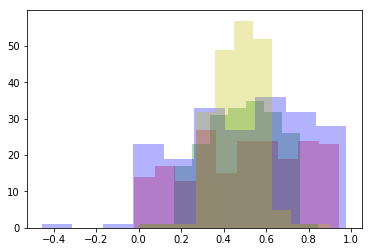

In [285]:
plt.hist(a, color = 'r', alpha = 0.3)
plt.hist(b, color = 'g', alpha = 0.3)
plt.hist(c, color = 'b', alpha = 0.3)
plt.hist(d, color = 'y', alpha = 0.3)

In [34]:
[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[%%time
ridge_solve(X, y, alpha = 2)][]--[[[[[[[-----[---]]]]]]]]

Wall time: 64.3 ms


array([0.83624554, 0.03380234, 0.5430859 , 0.41332906, 0.8320945 ,
       0.17436351, 0.25454977, 0.8915671 , 0.39349276, 0.94752824,
       0.7602116 , 0.66149724, 0.95449746, 0.84473073, 0.94992435,
       0.5758355 , 0.40707824, 0.80373806, 0.10123337, 0.17034745,
       0.27522388, 0.36991042, 0.8470976 , 0.3799943 , 0.67145663,
       0.0485044 , 0.60946906, 0.9260602 , 0.43024987, 0.6458963 ,
       0.24803795, 0.42066574, 0.6045591 , 0.41044253, 0.07396811,
       0.07456371, 0.08042842, 0.9101907 , 0.91457176, 0.30503413,
       0.6071965 , 0.37406138, 0.21456064, 0.81394696, 0.33203754,
       0.763892  , 0.6790081 , 0.6813604 , 0.69609046, 0.33636668,
       0.73115075, 0.838784  , 0.6211619 , 0.92308974, 0.37518638,
       0.6938305 , 0.20850843, 0.8965549 , 0.6139345 , 0.49631262,
       0.6316336 , 0.40065506, 0.26190704, 0.23873189, 0.6923202 ,
       0.79066235, 0.6865158 , 0.09583098, 0.5015134 , 0.3843173 ,
       0.24951595, 0.6505361 , 0.5527284 , 0.06215225, 0.58389

In [23]:
%%time
Q, R = qr(X)
U, S, VT = svd(X)

Wall time: 126 ms


In [118]:
_XTX, h = svd_stats(U, S, VT)
_XTX.dot( dot(X.T, X) ).diagonal().round(3).sum()

100.0

In [119]:
_XTX, h = qr_stats(Q, R)
_XTX.dot( dot(X.T, X) ).diagonal().round(3).sum()

100.013

In [62]:
%%time
j = _fast_QR_solve(X.astype(np_float64), y.astype(np_float64))

Wall time: 12.1 s


In [27]:
%%time
j = np_lstsq(X.astype(np_float64), y); j = None; gc.collect();

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


Wall time: 7.9 s


In [31]:
%%time
j = qr(X.astype(np_float64)); j = None; gc.collect();

Wall time: 12.3 s


In [28]:
%%time
j = _STABLE_LSTSQ(X.astype(np_float64), y, check_finite = False); j = None; gc.collect();

Wall time: 8.04 s


In [29]:
%%time
j = lstsq(X.astype(np_float64), y); j = None; gc.collect();

Wall time: 7.76 s


In [59]:
%%time
U, S, VT = svd(X)

AttributeError: Failed at nopython (nopython frontend)
'Signature' object has no attribute 'items'

In [119]:
@jit(nopython = True, fastmath = True)
def numpy_svd(X):
    return np.linalg.svd(X, full_matrices = False)

@njit(signature_or_function = float32[:](matrix32, float32[:]), fastmath = True)
def numpy_solve_float32_float32(X, y):
    theta_hat, __, __, __ = np.linalg.lstsq(X, y)
    return theta_hat
    
@jit(fastmath = True)
def scipy_solve(X, y):
    return _STABLE_LSTSQ(X, y, check_finite = False)

@njit(signature_or_function = float32[:](matrix32, float32[:]), fastmath = True, nogil = True)
def svd_solve_float32_float32(X, y):
    U, S, VT = np.linalg.svd(X, full_matrices = False)
    S[ S < np.finfo(X.dtype).eps*S[0] ] = 0
    VT *= np.divide(1, S).reshape(-1,1)
    theta_hat = VT.T.dot(U.T.dot(y))
    return theta_hat

@njit(  Tuple((matrix32, float32[:], matrix32))  (matrix32)  , fastmath = True)
def FastSVD(X):
    U, S, VT = np.linalg.svd(X, full_matrices = False)
    S[ S < np.finfo(X.dtype).eps*S[0] ] = 0
    return U, S, VT

@njit(  Tuple((matrix32, matrix32))  (matrix32)  , fastmath = True)
def FastQR(X):
    Q, R = np.linalg.qr(X)
    return Q, R


def svd_solve(X, y):
    return svd_solve_float32_float32(X, y.astype(np.float32).ravel())

def np_solve(X, y):
    return numpy_solve_float32_float32(X, y.astype(np.float32).ravel())

@jit(fastmath = True)
def scipy_svd_solve(X, y):
    y = y.astype(X.dtype)
    U, S, VT = sci.linalg.svd(X, full_matrices = False, check_finite = False)
    S[ S < np.finfo(X.dtype).eps*S[0] ] = 0
    VT *= np.divide(1, S).reshape(-1,1)
    theta_hat = VT.T.dot(U.T.dot(y))
    return theta_hat

@jit(fastmath = True)
def scipy_svd(X):
    return _STABLE_SVD(X, check_finite = False, full_matrices = False)

@jit(fastmath = True)
def scipy_qr(X):
    return _STABLE_QR(X, check_finite = False, full_matrices = False)

@jit(nopython = True, fastmath = True)
def numpy_qr(X):
    return np.linalg.qr(X, full_matrices = False)

In [56]:
numba.typeof(np.linalg.pinv(X[:100]))

array(float32, 2d, C)

In [51]:
numba.typeof(np.linalg.svd(X[:100]))

(array(float32, 2d, C), array(float32, 1d, C), array(float32, 2d, C))

In [47]:
import numba

In [98]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept = False, n_jobs = -1, normalize = False)

In [99]:
%%time
model.fit(X, y)

Wall time: 1.51 s


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=-1, normalize=False)

In [89]:
%%time
t = svd_solve(X, y)

Wall time: 1.31 s


In [38]:
%%time
t = _STABLE_LSTSQ(X, y, check_finite = False)

Wall time: 5.27 s


In [66]:
%%time
t = numpy_svd_solve(X, y)

TypeError: No matching definition for argument type(s) array(float32, 2d, C), array(int32, 1d, C)

In [52]:
t

array([ 0.37609762,  0.6849389 ,  0.490368  , -0.33477485,  0.6344189 ,
        0.0812725 ,  0.4126636 ,  0.9172979 ,  0.39229828,  0.69564456,
        0.25125992,  0.9819958 ,  0.48106527,  0.18152371,  0.8634224 ,
        0.67742884,  0.46907997,  0.17744243,  0.94744706,  0.37765136,
        0.6825141 ,  0.64447606,  0.41241986,  0.7559644 ,  0.22906035,
        0.27052814,  0.7066679 ,  0.82441086,  0.13688394,  0.08443773,
        0.5466825 ,  0.6709138 ,  0.04828939,  0.3239796 ,  0.12384185,
        0.28528306,  0.04094988,  0.9517988 ,  0.47516128,  0.54408145,
        0.73381335,  0.6551062 ,  0.2120508 ,  0.60940856,  0.9696851 ,
        0.83221614,  0.29709738,  0.5139408 ,  0.7273946 ,  0.68955237,
        0.5749271 ,  0.7917341 ,  0.41279525,  0.2309106 ,  0.8165032 ,
        0.4643569 ,  0.42354813,  0.44946468,  0.89597034,  0.77430207,
        0.9573589 ,  0.5155712 ,  0.1135404 ,  0.8872491 ,  0.16153115,
        0.30512428,  0.30776763,  0.36638713,  0.6178235 ,  0.19

In [49]:
help(jit)

Help on function jit in module numba.decorators:

jit(signature_or_function=None, locals={}, target='cpu', cache=False, pipeline_class=None, **options)
    This decorator is used to compile a Python function into native code.
    
    Args
    -----
    signature:
        The (optional) signature or list of signatures to be compiled.
        If not passed, required signatures will be compiled when the
        decorated function is called, depending on the argument values.
        As a convenience, you can directly pass the function to be compiled
        instead.
    
    locals: dict
        Mapping of local variable names to Numba types. Used to override the
        types deduced by Numba's type inference engine.
    
    target: str
        Specifies the target platform to compile for. Valid targets are cpu,
        gpu, npyufunc, and cuda. Defaults to cpu.
    
    pipeline_class: type numba.compiler.BasePipeline
            The compiler pipeline type for customizing the compilatio

In [46]:
numpy_svd_solve.inspect_types()

numpy_svd_solve (array(float32, 2d, C), array(int32, 1d, C))
--------------------------------------------------------------------------------
# File: <ipython-input-41-6e32ca82cfd2>
# --- LINE 14 --- 
# label 0

@njit(fastmath = True)

# --- LINE 15 --- 

def numpy_svd_solve(X, y):

    # --- LINE 16 --- 
    #   X = arg(0, name=X)  :: array(float32, 2d, C)
    #   y = arg(1, name=y)  :: array(int32, 1d, C)
    #   $0.2 = getattr(value=y, attr=astype)  :: BoundFunction(array.astype for array(int32, 1d, C))
    #   del y
    #   $0.4 = getattr(value=X, attr=dtype)  :: dtype(float32)
    #   $0.5 = call $0.2($0.4, func=$0.2, args=[Var($0.4, <ipython-input-41-6e32ca82cfd2> (16))], kws=(), vararg=None)  :: (dtype(float32),) -> array(float32, 1d, C)
    #   del $0.4
    #   del $0.2
    #   y.1 = $0.5  :: array(float32, 1d, C)
    #   del $0.5

    y = y.astype(X.dtype)

    # --- LINE 17 --- 
    #   $0.6 = global(np: <module 'numpy' from 'C:\\Users\\danie\\Anaconda3\\lib\\site-packages\\n

In [8]:
%%time
t = scipy_svd_solve(X, y)

Wall time: 24.5 s


In [7]:
%%time
U, S, VT = numpy_svd(X); U = S = VT = None; gc.collect();

Wall time: 4.18 s


In [ ]:
%%time


In [6]:
%%time
U, S, VT = scipy_svd(X); U = S = VT = None; gc.collect();

Wall time: 4.81 s


In [4]:
%%time
U, S, VT = _STABLE_SVD(X, check_finite = False, full_matrices = False); U = S = VT = None; gc.collect();

Wall time: 4.51 s


In [5]:
%%time
U, S, VT = np.linalg.svd(X, full_matrices = False); U = S = VT = None; gc.collect();

Wall time: 10.2 s


In [3]:
from copy import deepcopy
t = deepcopy(X)
gc_base = %timeit -o -n5 -r7 -p7   t = None; gc.collect();
gc_base = np.mean(gc_base.timings)
gc_base

32.02313 ms ± 338.6694 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


0.032023133720934564

In [4]:
x = %timeit -n1 -r3 -o -p7 U, S, VT = _STABLE_SVD(X, full_matrices = False, check_finite = False); U = S = VT = None; gc.collect();
x.timings = np.array(x.timings)-gc_base
results.append(np.mean(x.timings))
results.append(np.std(x.timings))
x = U = S = VT = None; gc.collect();

base = %memit -r1 -t1 -i1 -o
base = base.mem_usage[0]

m = %memit -r1 -t1 -i1 -o   U, S, VT = _STABLE_SVD(X, full_matrices = False, check_finite = False); U = S = VT = None; gc.collect();
results.append(m.mem_usage[0]-base); print(results[-1])
m = U = S = VT = None; gc.collect();

741.7615 ms ± 1.351908 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
peak memory: 117.95 MiB, increment: 0.02 MiB
peak memory: 139.69 MiB, increment: 21.74 MiB
21.73828125


In [5]:
x = %timeit -n1 -r3 -o -p7      U, S, VT, i = _transpose_svd(X); U = S = VT = None; gc.collect();
x.timings = np.array(x.timings)-gc_base
U, S, VT, i = _transpose_svd(X); U = S = VT = None; gc.collect();
if i == 0:
    results += [np.nan, np.nan, np.nan, np.nan]
else:
    results.append(np.mean(x.timings))
    results.append(np.std(x.timings))
    
    base = %memit -r1 -t1 -i1 -o
    base = base.mem_usage[0]

    m = %memit -r1 -t1 -i1 -o               U, S, VT, i = _transpose_svd(X); U = S = VT = None; gc.collect();
    results.append(m.mem_usage[0]-base); print(results[-1])
    m = base = U = S = VT = None; gc.collect();

31.80941 ms ± 1.598906 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [6]:
x = %timeit -n1 -r3 -o -p7       U, S, VT = _fast_svd(X); U = S = VT = None; gc.collect();
x.timings = np.array(x.timings)-gc_base
results.append(np.mean(x.timings))
results.append(np.std(x.timings))
x = U = S = VT = None; gc.collect();

base = %memit -r1 -t1 -i1 -o
base = base.mem_usage[0]

m = %memit -r1 -t1 -i1 -o               U, S, VT = _fast_svd(X); U = S = VT = None; gc.collect();
results.append(m.mem_usage[0]-base); print(results[-1])
m = base = U = S = VT = None; gc.collect();

979.7919 ms ± 1.831457 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
peak memory: 119.45 MiB, increment: 0.03 MiB
peak memory: 148.78 MiB, increment: 29.33 MiB
29.328125


In [7]:
x = %timeit -n1 -r3 -o -p7       Q, R, theta_hat = _fast_QR_solve(X, y);  Q = R = theta_hat = None; gc.collect();
x.timings = np.array(x.timings)-gc_base
results.append(np.mean(x.timings))
results.append(np.std(x.timings))
x = Q = R = theta_hat = None; gc.collect();

base = %memit -r1 -t1 -i1 -o
base = base.mem_usage[0]

m = %memit -r1 -t1 -i1 -o               Q, R, theta_hat = _fast_QR_solve(X, y);  Q = R = None; gc.collect();
results.append(m.mem_usage[0]-base); print(results[-1])
results.append( np.square(y - X.dot(theta_hat)).sum() / n )
m = theta_hat = None
gc.collect();

250.285 ms ± 1.237761 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
peak memory: 123.89 MiB, increment: 0.00 MiB
peak memory: 135.34 MiB, increment: 11.45 MiB
11.453125


In [8]:
x = %timeit -n1 -r3 -o -p7       theta_hat = _STABLE_LSTSQ(X, y, check_finite = False)[0]; theta_hat = None; gc.collect();
x.timings = np.array(x.timings)-gc_base
results.append(np.mean(x.timings))
results.append(np.std(x.timings))
x = theta_hat = None; gc.collect();

base = %memit -r1 -t1 -i1 -o
base = base.mem_usage[0]

m = %memit -r1 -t1 -i1 -o               theta_hat = _STABLE_LSTSQ(X, y, check_finite = False)[0]; gc.collect();
results.append(m.mem_usage[0]-base); print(results[-1])
results.append( np.square(y - X.dot(theta_hat)).sum() / n )
m = theta_hat = None; gc.collect();

678.877 ms ± 3.904436 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
peak memory: 124.21 MiB, increment: -0.06 MiB
peak memory: 131.85 MiB, increment: 7.64 MiB
7.63671875


In [9]:
x = %timeit -n1 -r3 -o -p7       theta_hat = _svd_solve(X, y); theta_hat = None; gc.collect();
x.timings = np.array(x.timings)-gc_base
results.append(np.mean(x.timings))
results.append(np.std(x.timings))
x = theta_hat = None; gc.collect();

base = %memit -r1 -t1 -i1 -o
base = base.mem_usage[0]

m = %memit -r1 -t1 -i1 -o               theta_hat = _svd_solve(X, y); gc.collect();
results.append(m.mem_usage[0]-base); print(results[-1])
results.append( np.square(y - X.dot(theta_hat)).sum() / n )
m = theta_hat = None; gc.collect();

752.7342 ms ± 3.848582 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
peak memory: 124.25 MiB, increment: 0.00 MiB
peak memory: 145.92 MiB, increment: 21.68 MiB
21.67578125


In [10]:
Q, R = _STABLE_QR(X, check_finite = False, mode = 'economic')
XTX = X.T.dot(X)

x = %timeit -n1 -r3 -o -p7       _XTX, h = _qr_stats(Q, R); _XTX = h = None; gc.collect();
x.timings = np.array(x.timings)-gc_base
results.append(np.mean(x.timings))
results.append(np.std(x.timings))
x = _XTX = h = None; gc.collect();

base = %memit -r1 -t1 -i1 -o
base = base.mem_usage[0]

m = %memit -r1 -t1 -i1 -o               _XTX, h = _qr_stats(Q, R)
results.append(m.mem_usage[0]-base); print(results[-1])
results.append( _XTX.dot(XTX).round(3).sum() )
results.append( h.sum() )
_XTX = h = None
gc.collect();

Q = R = None
gc.collect();

728.1642 ms ± 2.185719 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
peak memory: 136.06 MiB, increment: 0.00 MiB
peak memory: 163.12 MiB, increment: 27.06 MiB
27.0625


In [11]:
U, S, VT = _STABLE_SVD(X, full_matrices = False, check_finite = False);

x = %timeit -n1 -r3 -o -p7      _XTX, h = _svd_stats(U, S, VT); _XTX = h = None; gc.collect();
x.timings = np.array(x.timings)-gc_base
results.append(np.mean(x.timings))
results.append(np.std(x.timings))
x = _XTX = h = None; gc.collect();

base = %memit -r1 -t1 -i1 -o
base = base.mem_usage[0]

m = %memit -r1 -t1 -i1 -o              _XTX, h = _svd_stats(U, S, VT)
results.append(m.mem_usage[0]-base); print(results[-1])
results.append( _XTX.dot(XTX).round(3).sum() )
results.append( h.sum() )
_XTX = h = None
gc.collect();

U = S = VT = None
gc.collect();

55.36467 ms ± 262.4967 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
peak memory: 136.08 MiB, increment: 0.00 MiB
peak memory: 147.53 MiB, increment: 11.45 MiB
11.44921875


In [12]:
x = %timeit -n1 -r3 -o -p7      _XTX, h = _pinv_stats(X); _XTX = h = None; gc.collect();
x.timings = np.array(x.timings)-gc_base
results.append(np.mean(x.timings))
results.append(np.std(x.timings))
x = _XTX = h = None; gc.collect();

base = %memit -r1 -t1 -i1 -o
base = base.mem_usage[0]

m = %memit -r1 -t1 -i1 -o              _XTX, h = _pinv_stats(X)
results.append(m.mem_usage[0]-base); print(results[-1])
results.append( _XTX.dot(XTX).round(3).sum() )
results.append( h.sum() )
_XTX = h = None
gc.collect();


x = pd.DataFrame(results).T
x.to_csv(f'Timings/Timings{n}-{p}.csv', index = False)
print('Done')

1.468771 s ± 3.263069 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
peak memory: 128.46 MiB, increment: 0.00 MiB
peak memory: 159.32 MiB, increment: 30.87 MiB
30.8671875
Done


In [13]:
results

[1000,
 1000,
 0.7097384090280096,
 0.0013519082102765659,
 21.73828125,
 nan,
 nan,
 nan,
 nan,
 0.9477687548335516,
 0.0018314567863154264,
 29.328125,
 0.21826181964563218,
 0.0012377605183208477,
 11.453125,
 1.1534714869698178e-08,
 0.6468539037429971,
 0.0039044356867185444,
 7.63671875,
 4.993456713435348e-26,
 0.7207110720392094,
 0.003848581824639269,
 21.67578125,
 1.9433296442342043e-08,
 0.6961410313669739,
 0.0021857188622617985,
 27.0625,
 998.18005,
 1000.0,
 0.023341531324330783,
 0.0002624966674508946,
 11.44921875,
 -4063.9167,
 1000.0,
 1.4367480150617398,
 0.0032630688822259703,
 30.8671875,
 998.0572,
 995.0]